In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
train = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val = "/kaggle/input/chest-xray-pneumonia//chest_xray/val"
test = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [3]:
# Define the input shape of the images (assuming RGB images)
input_shape = (224, 224, 3)

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
# Create a data generator for loading and augmenting the images
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = datagen.flow_from_directory(
    train,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_directory(
    val,
    target_size=input_shape[:2],
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
test_generator = datagen.flow_from_directory(
    test,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [21]:
# Create a CNN model for anomaly detection
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'],)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [10]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
163/163 [==============================] - 95s 506ms/step - loss: 2.1731 - accuracy: 0.7318 - val_loss: 0.5611 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 57s 351ms/step - loss: 0.3480 - accuracy: 0.7481 - val_loss: 0.5109 - val_accuracy: 0.7580
Epoch 3/10
163/163 [==============================] - 60s 366ms/step - loss: 0.2943 - accuracy: 0.9155 - val_loss: 1.4408 - val_accuracy: 0.6763
Epoch 4/10
163/163 [==============================] - 55s 339ms/step - loss: 0.2257 - accuracy: 0.9375 - val_loss: 1.4721 - val_accuracy: 0.7131
Epoch 5/10
163/163 [==============================] - 55s 336ms/step - loss: 0.1694 - accuracy: 0.9440 - val_loss: 1.3906 - val_accuracy: 0.7179


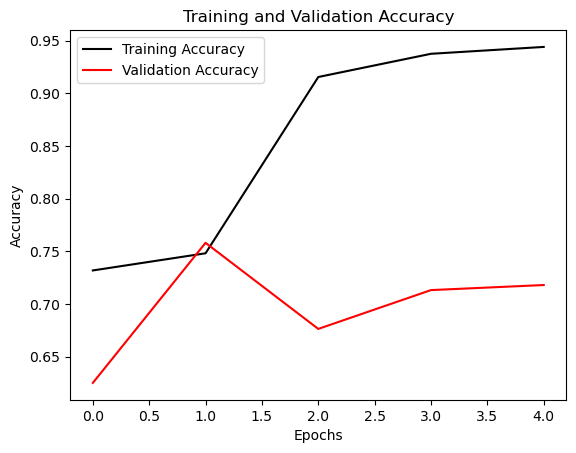

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='k')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='r')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

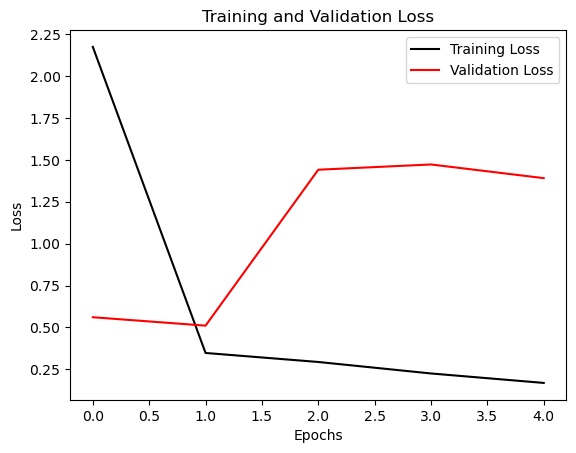

In [12]:
plt.plot(history.history['loss'], label='Training Loss', color='k')
plt.plot(history.history['val_loss'], label='Validation Loss', color='r')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

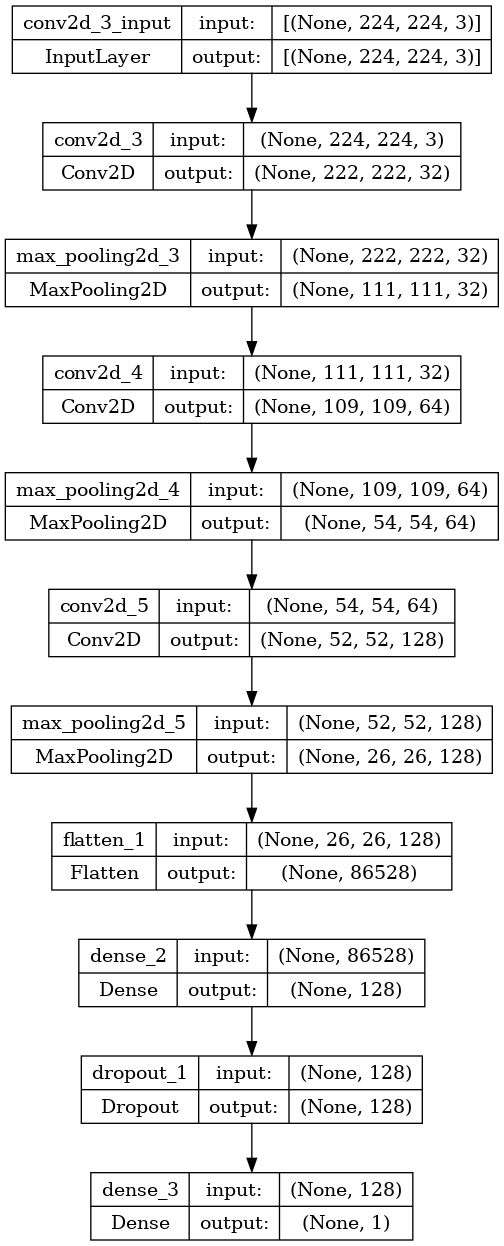

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

In [14]:
model.save("anamoly_detect.h5")

In [18]:
# Predict anomaly scores for the test images
anomaly_scores = model.predict(val_generator)

1/1 [==============================] - 0s 223ms/step


In [25]:
# Define a threshold for anomaly detection
threshold = 0.5

# Classify the test images as normal or anomalous based on the threshold
for i, score in enumerate(anomaly_scores):
    if score < threshold:
        classification = 'Normal'
        normal_image = val_generator[i][0][0] * 255.0  # Retrieve a normally classified image
        break

for i, score in enumerate(anomaly_scores):
    if score >= threshold:
        classification = 'Anomalous'
        anomalous_image = val_generator[i][0][0] * 255.0  # Retrieve an anomalous image
        break

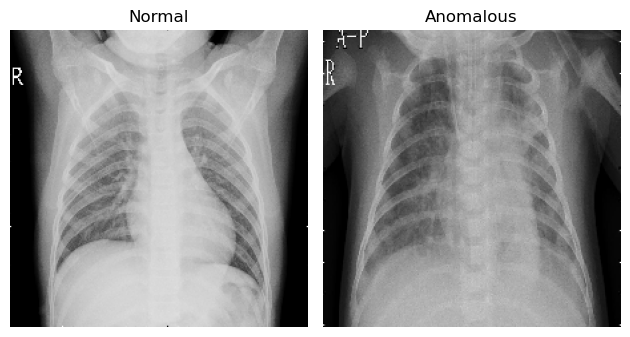

In [26]:
# Display the images and their classifications
plt.subplot(1, 2, 1)
plt.imshow(normal_image.astype(np.uint8))
plt.title('Normal')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(anomalous_image.astype(np.uint8))
plt.title('Anomalous')
plt.axis('off')

plt.tight_layout()
plt.show()
